In [1]:
# ====================================================================================
# Numerical Computation of VECTORIAL DIFFRACTION based on the Debye-Wolf Integral
# ====================================================================================
# Script written by Martin Regehly
# Please reference the publication "Split-Aperture Xolography – Linear volumetric
# photoactivation with short axial dimension and low out of focus excitation" for use

# import Python libraries
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [2]:
# set definitions of the system
# =================================================================
l=405E-9 # wavelength in m
#calculate angular wavenumber
k=2*np.pi/l

# refractive index of the homogeneous focussing media 
#n=1.0 #(air)
n=1.44+16823.71/(l*1.0E9)**2  #refractive index of monomer PETA at desired wavelength 

#define beam polarisation by jones vector
E=[1,0] # linear x polarised 
fx=0;fy=0

#focusing lens definitions 
#first option using the numerical aperture of the lens
#NA=0.95 
#alpha=np.arcsin(NA/n)
# second option by defining the focusing angle of the lens
alpha=np.arcsin(0.95)
#alpha=np.deg2rad(27.0)
# focal length in m - it is only a constant in the Debye-Wolf integral
# we choose an arbitrary value as we are not interested in absolute values of the electric field in the focal zone
f=1.6*1E-3
 
# generate a set of desired cartesian coordinates at which the PSF in the focus zone is to be calculated 
# this script is for an axial (1D) slice
startz=0*1E-9 # in m
stopz=2500*1E-9 # in m
spacez=1000 # number of points (significant influence on computation time)
zvals=np.linspace(startz, stopz, spacez)

# set up an array to store the 3 component electric field vector in the focal zone
Efield=np.empty((spacez,3),dtype=complex)
# generate an array to store the calculated intensity in the focal zone 
Intensity=np.empty((spacez),dtype=float)

print('Wavelength in nm: '+str(l*1E9))
print('Jones Vector Electric Field in the input plane: Ex, Ey, Phase x, Phase y',E,fx,fy)
print('Refractive index: '+str(n))
print("Focusing angle in rad: "+str(alpha))
print("Focusing angle in degree: "+str(np.rad2deg(alpha)))
print("Numerical aperture NA: "+str(n*np.sin(alpha)))


Wavelength in nm: 405.0
Jones Vector Electric Field in the input plane: Ex, Ey, Phase x, Phase y [1, 0] 0 0
Refractive index: 1.5425679622008839
Focusing angle in rad: 1.253235897503375
Focusing angle in degree: 71.80512766123321
Numerical aperture NA: 1.4654395640908395


In [3]:
#Integrand functions of the Debye-Wolf integrals 
#===============================================

#Integrand function for Ex field component, imaginary part 
def DebyeWolfIntegrandx_imag(theta,psi):
    #calculate g
    g=n*k*(radii*np.sin(theta)*np.cos(psi-angle)+za*np.cos(theta))
    #Matrix Elements       
    a11=np.cos(theta)+1.0+(np.cos(theta)-1.0)*np.cos(2*psi)
    a12=(np.cos(theta)-1.0)*np.sin(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a11*np.cos(fx+g)+E[1]*a12*np.cos(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ex field component, real part 
def DebyeWolfIntegrandx_real(theta,psi):
    #calculate g
    g=n*k*(radii*np.sin(theta)*np.cos(psi-angle)+za*np.cos(theta))
    #Matrix Elements       
    a11=np.cos(theta)+1.0+(np.cos(theta)-1.0)*np.cos(2*psi)
    a12=(np.cos(theta)-1.0)*np.sin(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a11*np.sin(fx+g)+E[1]*a12*np.sin(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ey field component, imaginary part     
def DebyeWolfIntegrandy_imag(theta,psi):
    #calculate g, part of the integrand
    g=n*k*(radii*np.sin(theta)*np.cos(psi-angle)+za*np.cos(theta))
    #Matrix Elements  
    a21=(np.cos(theta)-1)*np.sin(2*psi)
    a22=np.cos(theta)+1-(np.cos(theta)-1)*np.cos(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a21*np.cos(fx+g)+E[1]*a22*np.cos(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ey field component, real part  
def DebyeWolfIntegrandy_real(theta,psi):
    #calculate g
    g=n*k*(radii*np.sin(theta)*np.cos(psi-angle)+za*np.cos(theta))
    #Matrix Elements  
    a21=(np.cos(theta)-1)*np.sin(2*psi)
    a22=np.cos(theta)+1-(np.cos(theta)-1)*np.cos(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a21*np.sin(fx+g)+E[1]*a22*np.sin(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ez field component, imaginary part  
def DebyeWolfIntegrandz_imag(theta,psi):
    #calculate g
    g=n*k*(radii*np.sin(theta)*np.cos(psi-angle)+za*np.cos(theta))
    #Matrix Elements  
    a31=-2*np.sin(theta)*np.cos(psi)
    a32=-2*np.sin(theta)*np.sin(psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a31*np.cos(fx+g)+E[1]*a32*np.cos(fy+g))*np.sin(theta)
    return Integrand
    
#Integrand function for Ez field component, real part 
def DebyeWolfIntegrandz_real(theta,psi):
    #calculate g
    g=n*k*(radii*np.sin(theta)*np.cos(psi-angle)+za*np.cos(theta))
    #Matrix Elements  
    a31=-2*np.sin(theta)*np.cos(psi)
    a32=-2*np.sin(theta)*np.sin(psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a31*np.sin(fx+g)+E[1]*a32*np.sin(fy+g))*np.sin(theta)
    return Integrand    


In [ ]:
# Calculate complex Ex, Ey, Ez Field Components by performing computation of the Debye-Wolf-Integrals

x=0
y=0
for indz,za in enumerate(zvals):
    #y=np.tan(alpha/2)*za # allows to calculate the 1dim PSF in the ZY plane along a path s with angle alpha/2 emanating from focus (see paper for details)  
    radii=np.sqrt(x*x+y*y) #transform from cartesian to cylindrical coordinates
    angle=np.arctan2(y,x)  
        
    # Full aperture illumination
    imag_x=integrate.dblquad(DebyeWolfIntegrandx_imag,0, 2*np.pi, lambda x: 0,lambda x: alpha)
    real_x=integrate.dblquad(DebyeWolfIntegrandx_real,0, 2*np.pi, lambda x: 0,lambda x: alpha)
    imag_y=integrate.dblquad(DebyeWolfIntegrandy_imag,0, 2*np.pi, lambda x: 0,lambda x: alpha)
    real_y=integrate.dblquad(DebyeWolfIntegrandy_real,0, 2*np.pi, lambda x: 0,lambda x: alpha)
    imag_z=integrate.dblquad(DebyeWolfIntegrandz_imag,0, 2*np.pi, lambda x: 0,lambda x: alpha)
    real_z=integrate.dblquad(DebyeWolfIntegrandz_real,0, 2*np.pi, lambda x: 0,lambda x: alpha)
        
    #Half illuminated aperture (upper: np.pi,2*np.pi, lower: 0,np.pi )
    #imag_x=integrate.dblquad(DebyeWolfIntegrandx_imag,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
    #real_x=integrate.dblquad(DebyeWolfIntegrandx_real,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
    #imag_y=integrate.dblquad(DebyeWolfIntegrandy_imag,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
    #real_y=integrate.dblquad(DebyeWolfIntegrandy_real,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
    #imag_z=integrate.dblquad(DebyeWolfIntegrandz_imag,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
    #real_z=integrate.dblquad(DebyeWolfIntegrandz_real,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        
    #calculate electric field components from results
    Ex = -(1.0j*n*k*f)/(2.0*np.pi)*imag_x[0]+(n*k*f)/(2.0*np.pi)*real_x[0]
    Ey = -(1.0j*n*k*f)/(2.0*np.pi)*imag_y[0]+(n*k*f)/(2.0*np.pi)*real_y[0]
    Ez = -(1.0j*n*k*f)/(2.0*np.pi)*imag_z[0]+(n*k*f)/(2.0*np.pi)*real_z[0]
    #store electric field components in result array    
    Efield[indz,0]=Ex
    Efield[indz,1]=Ey
    Efield[indz,2]=Ez
          
    print(indz,za,Ex,Ey,Ez)

In [ ]:
# Save calculated complex electric field components (x,y,z)
np.save("Efield_405nm_Na1-46_fullaper_1000_xpol_PSF_Z.npy",Efield)

In [4]:
# Load calculated complex electric field components (x,y,z)
Efield=np.load("Efield_405nm_Na1-46_fullaper_1000_xpol_PSF_Z.npy")

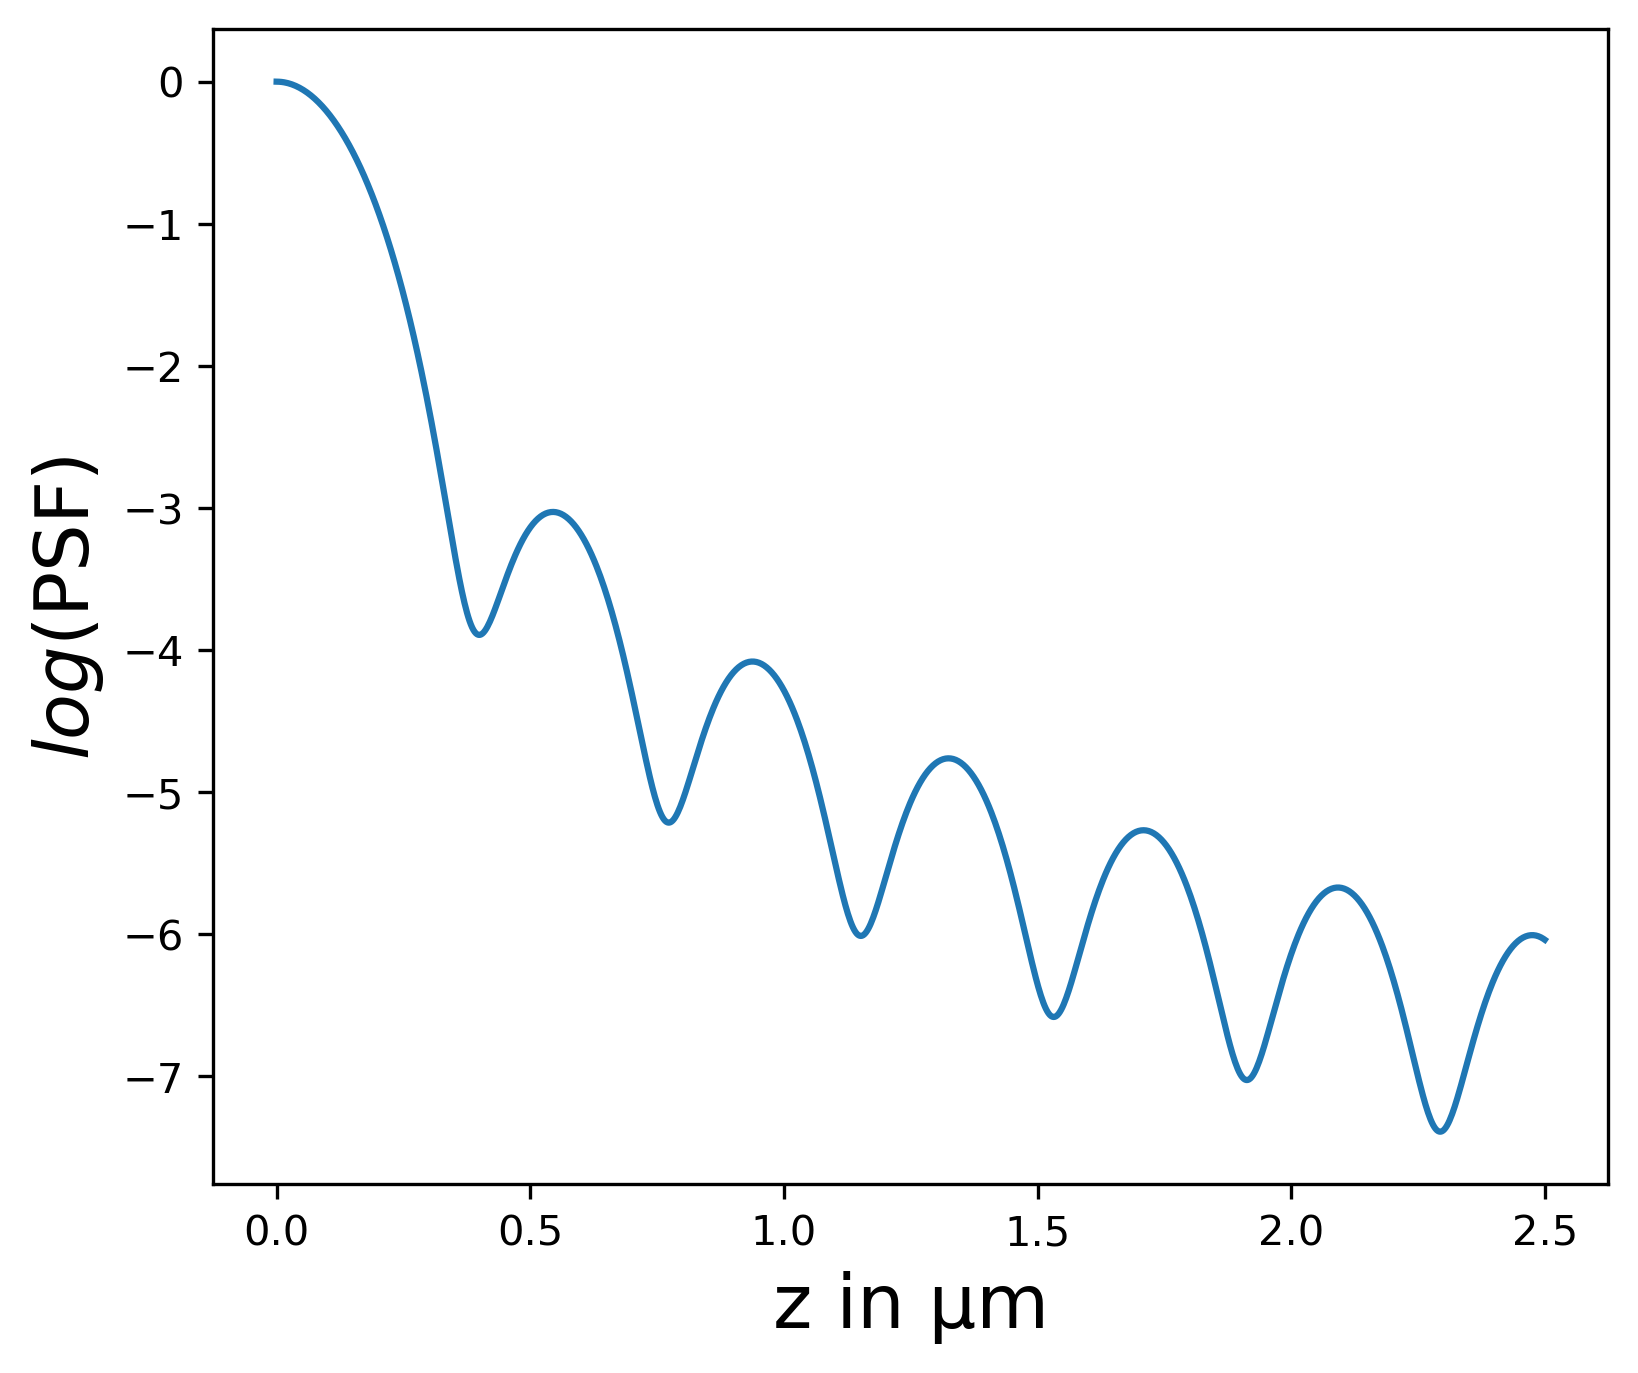

In [5]:
Intensity=np.real(Efield[:,0]*np.conj(Efield[:,0])+Efield[:,1]*np.conj(Efield[:,1])+Efield[:,2]*np.conj(Efield[:,2]))
c=Intensity[:].max()    # here we normalize the result to obtain the PSF
Intensity[:]=Intensity[:]/c     

# plot normalized Intensity / PSF
fig, ax = plt.subplots(figsize=(6,5),dpi=300)

plt.plot(zvals*1E6,np.log(Intensity))
plt.xlabel('z in \u03BCm', fontsize=18)
ax.set_ylabel('$log$(PSF)', fontsize=18)

#plt.savefig("I2_810nm_Na1-4_fullaper_xpol_axial_HHRes.png")
plt.show()